# Sales Data Analysis

In [26]:
from glob import glob
from numpy import sqrt
from scipy import stats

import numpy as np
import pandas as pd
import plotly.express as px
import random

In [27]:
# read all files
weeks = [pd.read_csv(filename) for filename in glob("./data/*.csv")]

# should print 50
print("Amount of files imported:", len(weeks))

# create a df from files
df = pd.concat(weeks, axis=0)
df.reset_index()
df.tail()

Amount of files imported: 50


,sale_time,purchaser_gender
4760,2013-06-30 22:55:52,female
4761,2013-06-30 23:03:21,male
4762,2013-06-30 23:04:52,male
4763,2013-06-30 23:11:30,female
4764,2013-06-30 23:16:38,female


### Question 1
**Plot daily sales for all 50 weeks**

In [28]:
# setting appropriate data type for the timestamp column
df["sale_time"] = pd.to_datetime(df["sale_time"])

# grouping everythig by day and renaming the columns to avoid confusion
df_grouped = df.groupby(
    [pd.Grouper(key="sale_time", freq="D")],
     as_index=False).agg(total_sales = ("sale_time", "count"))
df_grouped = df_grouped.rename(columns={"sale_time": "sale_day"})

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204329 entries, 0 to 4764
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   sale_time         204329 non-null  datetime64[ns]
 1   purchaser_gender  204329 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 4.7+ MB


There is no NaN values in the dataset, and all data types are correct, so there is no need for preliminary cleaning

<Axes: title={'center': 'Daily sales over 50 weeks'}>

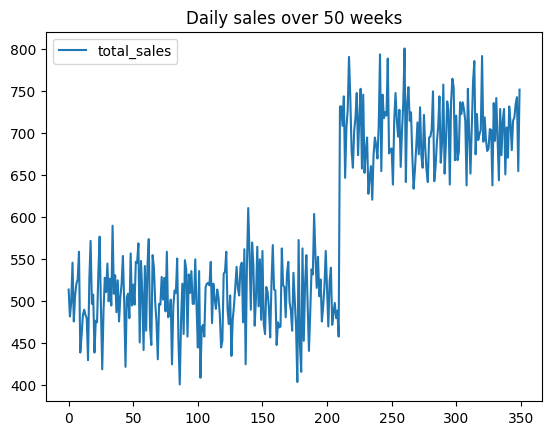

In [29]:
df_grouped[["total_sales"]].plot(title="Daily sales over 50 weeks")

### Question 2
**It looks like there has been a sudden change in daily sales. What date did it occur?**

In [30]:
df_grouped["sales_diff"] = df_grouped["total_sales"].diff()
print("Date of the sudden change in sales:")
day_x = df_grouped.loc[df_grouped["sales_diff"] == df_grouped["sales_diff"].max()]["sale_day"].iloc[0]
max_total_sales = df_grouped.loc[df_grouped["sales_diff"] == df_grouped["sales_diff"].max()]
max_total_sales

Date of the sudden change in sales:


,sale_day,total_sales,sales_diff
210,2013-04-29,732,274.0


### Question 3
**Is the change in daily sales at the date you selected statisticalle significant? If so what is the p-value?**

In [31]:
print("Mean:", df_grouped[df_grouped["sale_day"] >= pd.to_datetime("2013-04-29")]["total_sales"].mean())
print("n:", df_grouped[df_grouped["sale_day"] >= pd.to_datetime("2013-04-29")].size)
print("Std:", df_grouped[df_grouped["sale_day"] >= pd.to_datetime("2013-04-29")]["total_sales"].std())

Mean: 702.8928571428571
n: 420
Std: 39.32463968992004


In [32]:
# doing 1-sample t-test to obtain p-value more or less manually

# (observed value - mean ) / (Standard Deviation of population (but here we estimating this using SD of our samplpe) / sq_root(number of observations))
#  _
#  x - mu
# --------
#   SD
#  -----
#   __
#  V n

x_bar = max_total_sales["total_sales"].values[0]
mu = df_grouped["total_sales"].mean()
sd = df_grouped["total_sales"].std()
n = len(df_grouped["total_sales"])

t_stat = (x_bar - mu) / ( sd / sqrt(n))
print("t_stat:", t_stat)

t_stat: 26.367553024439697


In [33]:
# doint 1-sample t-test to obtain p-value using scipy
stats.ttest_1samp(df_grouped['total_sales'], 732)

TtestResult(statistic=np.float64(-26.367553024439697), pvalue=np.float64(4.5681432390066193e-85), df=np.int64(349))

Let's try some code from book Stistics for Data Scientist

In [34]:
# separate data to before and after 2013-04-29

bins = [df_grouped["sale_day"].iloc[0], df_grouped["sale_day"].iloc[210], df_grouped["sale_day"].iloc[-1]]
labels = ["Before", "After"]
df_grouped["bins"] = pd.cut(df_grouped["sale_day"], right=False, bins=bins, labels=labels)
df_grouped.loc[df_grouped.index[-1], "bins"] = "After"

In [35]:
px.box(df_grouped,  x="bins", y="total_sales")

In [36]:
mean_before = df_grouped[df_grouped["sale_day"] < day_x].total_sales.mean()
mean_after =  df_grouped[df_grouped["sale_day"] >= day_x].total_sales.mean()
mean_after - mean_before

np.float64(198.49285714285713)

After "Day X" (2013-04-29) the sales increased by 198.49 on average. The question is whether this difference is within the range of what random chance might produce or not. One way to answer this is to apply a permutation test -- combine all the sessions together and then repeatedly shuffle and divide them into groups of `n_a == 210` and `n_b == 140`.

In [37]:
n_a = df_grouped[df_grouped["bins"] == "Before"]["sale_day"].count()
n_b = df_grouped[df_grouped["bins"] == "After"]["sale_day"].count()
print(n_a, n_b)

210 140


In [38]:
# doing 10000 random permutation of our data to find out how likely it is to get the observed result

def perm_func(x, n_a, n_b) :
    n = n_a + n_b
    idx_B = set(random.sample(range(n), n_b))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

perm_diffs = [perm_func(df_grouped.total_sales, n_a, n_b) for _ in range(10000)]


In [39]:
fig = px.histogram(perm_diffs)
fig.add_vline(x=mean_after - mean_before, line_color = "lightcoral", annotation_text='Observed\ndifference')

In [40]:
obs_pct_diff = (mean_after - mean_before)
print(f"Observed difference: {obs_pct_diff:.4f} sales")

p_value = np.mean([diff > obs_pct_diff for diff in perm_diffs])
print(f"p-value: {p_value:.100f}")

Observed difference: 198.4929 sales
p-value: 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


### Question 4
**Does the data suggest that the change in daily sales is due to the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary)**

In [41]:
gender_proportion_df = df.groupby([
    pd.Grouper(key="sale_time", freq="D"),
    pd.Grouper(key="purchaser_gender")], 
    as_index=False
).agg(number_of_sales=("purchaser_gender", "count"))

In [42]:
new_df = df_grouped.merge(
    gender_proportion_df,
    left_on="sale_day",
    right_on="sale_time"
).drop("sale_time", axis=1).set_index(["sale_day"])

new_df["gender_ratio"] = new_df[new_df["purchaser_gender"] == "male"]["number_of_sales"] / new_df[new_df["purchaser_gender"] == "female"]["number_of_sales"]

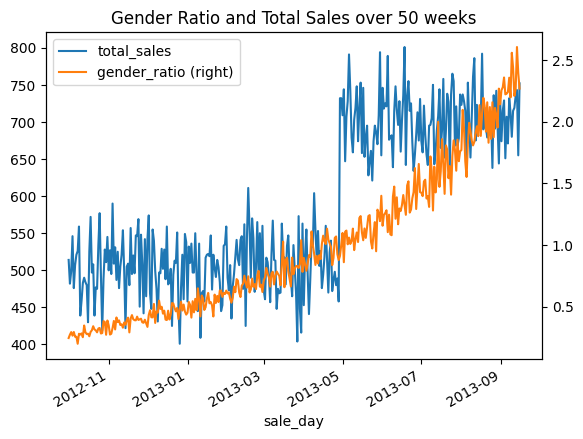

In [43]:
title = "Gender Ratio and Total Sales over 50 weeks"
plot = new_df[["total_sales", "gender_ratio"]].plot(title=title, secondary_y="gender_ratio")

The sudden change of sales could not be explained by the steady growth of male ratio. The reason should be further investigated.

### Question 5
**Assume a given day is divided into four dayparts:**
- night (12:00AM - 6:00AM),
- morning (6:00AM - 12:00PM),
- afternoon (12:00PM - 6:00PM),
- evening (6:00PM - 12:00AM).

**What is the percentage of sales in each daypart over all 50 weeks?**

In [44]:
# group by evety 6 hours starting from 00:00 of the very first day
daypart_sale_df = df.groupby([
    pd.Grouper(key="sale_time", freq="6h", origin="start_day", closed="left", label="left")
],
).agg(total_sales = ("sale_time", "count"))

In [45]:
total_sales = daypart_sale_df["total_sales"].sum()
columns = ["part_of_day", "sales", "ratio"]
day_parts = {
    "00:00": "night",
    "06:00": "morning",
    "12:00": "afternoon",
    "18:00": "evening"
}

new_df = pd.DataFrame(
    index=day_parts,
    columns=columns)

for time in new_df.index:
    new_df.loc[time, "part_of_day"] = day_parts[time]
    new_df.loc[time, "sales"] = daypart_sale_df["total_sales"].at_time(time).sum()
    new_df.loc[time, "ratio"] = daypart_sale_df["total_sales"].at_time(time).sum() / total_sales

new_df.head()

,part_of_day,sales,ratio
00:00,night,18306,0.089591
06:00,morning,62870,0.30769
12:00,afternoon,80533,0.394134
18:00,evening,42620,0.208585


Text(0.5, 0, 'Part of The Day')

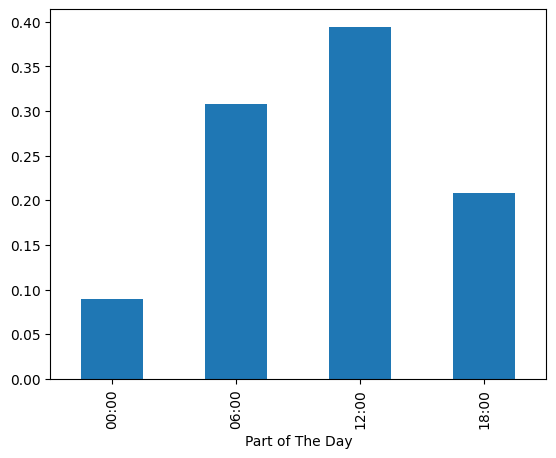

In [46]:
plot = new_df["ratio"].plot(kind="bar")
plot.set_xlabel("Part of The Day")